## Predict survival of Titanic passengers (2) - Modelling & Predictions

### To summarize, data will be preprocessed before model training:
- Extract 'title' from 'Name'
- Fill NA values in 'Age' with median age for the corresponding 'title'. For new 'title' not seen in training set, use overall median age
- Extract 'Cabin_Deck' from 'Cabin' (May want to exclude this eventually as too may NAs)
- Variables such as 'Cabin_Number', 'title', 'Fare', 'Ticket'  and 'Name' will be excluded due to too many missing values or irrelevance
- Additional categorical columns of whether passenger had any SibSp or Parch will be created
- Fill missing NA values in "Embarked" with mode


In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Preprocessing data sets

In [9]:
train=pd.read_csv("train.csv")

In [7]:
train['title'] = train['Name'].apply(lambda x:x.split(',')[1].split('.')[0].strip()) #extract titles from names

In [8]:
age_medians = {} #create dictionary of medians for each title using training set

for title in np.unique(train['title']):
    age_medians[title] = train['Age'][train['title']==title].median()

age_medians['overall'] = train['Age'].median()

In [73]:
def fill_age(df): #Fill NAs in "Age" based on median age for title. Use overall median age if title is not available in data
    title = df['title'].unique().item()
    if title in age_medians.keys():
        df['Age'] = df['Age'].fillna(age_medians[title])
    else:
        df['Age'] = df['Age'].fillna(age_medians['overall'])
    return df

def preproc(df):
    
    #fill missing age values
    df['title'] = df['Name'].apply(lambda x:x.split(',')[1].split('.')[0].strip()) #extract titles from names
    df = df.groupby('title').apply(lambda x: fill_age(x))
    
    #transform cabin info
    df['Cabin_Deck']= np.NaN
    df['Cabin_Number']=np.NaN
    df['Cabin_Deck'][~df['Cabin'].isna()]  = df['Cabin'][~df['Cabin'].isna()].apply(lambda x:x[0])
    df['Cabin_Number'][~df['Cabin'].isna()]  = df['Cabin'][~df['Cabin'].isna()].apply(lambda x:x[1:].split(' ')[0]) #retain only first booth number if entries have multiple booths
    df['Cabin_Number'] =  pd.to_numeric(df['Cabin_Number'], errors='coerce')
    
    #change Pclass to categorical var
    df['Pclass']=df['Pclass'].astype('str')
    
    #fill missing Embarked data
    df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode())
    
    #create categorical SibSp/Parch columns
    df["HasSibSp"] = 1
    df["HasParch"] = 1
    df.loc[df["SibSp"]==0,"HasSibSp"]=0
    df.loc[df["Parch"]==0,"HasParch"]=0
    
    #include only variables of interest
    variables = ["Pclass","Sex","Age","SibSp","Parch", "Embarked","HasSibSp", "HasParch", "Cabin_Deck"]
    
    df = df[variables]
    
    cat_var = ["Sex","Embarked","Pclass", "Cabin_Deck"]
    
    df = pd.get_dummies(df, columns=cat_var)
    
    return df


In [25]:
X = preproc(train)
y = train["Survived"]
test = pd.read_csv("test.csv")
labels = pd.read_csv("gender_submission.csv")

def add_missing_dummy_columns(train, test): #ensure test set has same columns as training set
    missing_cols = set(train.columns) - set(test.columns) 
    for c in missing_cols:
        test[c] = 0
    test = test[train.columns]
    return test

/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### Model training and predictions

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, f1_score

X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 21 columns):
Age             891 non-null float64
SibSp           891 non-null int64
Parch           891 non-null int64
HasSibSp        891 non-null int64
HasParch        891 non-null int64
Sex_female      891 non-null uint8
Sex_male        891 non-null uint8
Embarked_C      891 non-null uint8
Embarked_Q      891 non-null uint8
Embarked_S      891 non-null uint8
Cabin_Deck_A    891 non-null uint8
Cabin_Deck_B    891 non-null uint8
Cabin_Deck_C    891 non-null uint8
Cabin_Deck_D    891 non-null uint8
Cabin_Deck_E    891 non-null uint8
Cabin_Deck_F    891 non-null uint8
Cabin_Deck_G    891 non-null uint8
Cabin_Deck_T    891 non-null uint8
Pclass_1        891 non-null uint8
Pclass_2        891 non-null uint8
Pclass_3        891 non-null uint8
dtypes: float64(1), int64(4), uint8(16)
memory usage: 48.8 KB


In [59]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=101)

In [60]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train,y_train)
train_predictions = rf_model.predict(X_train)

print("Training accuracy is :{}".format(accuracy_score(y_train,train_predictions)))
print("Test accuracy is :{}".format(accuracy_score(y_test,rf_model.predict(X_test))))

Training accuracy is :0.9438202247191011
Test accuracy is :0.7611940298507462


In [61]:
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]
scores = []
for n in n_estimators:
    rf_model = RandomForestClassifier(n_estimators = n)
    rf_model.fit(X_train,y_train)
    predictions = rf_model.predict(X_test)
    scores.append(accuracy_score(y_test,predictions))

In [62]:
for n,score in zip(n_estimators,scores):
    print("{} estimators: score{}".format(n,score))

1 estimators: score0.746268656716418
2 estimators: score0.7238805970149254
4 estimators: score0.7611940298507462
8 estimators: score0.7910447761194029
16 estimators: score0.7611940298507462
32 estimators: score0.7686567164179104
64 estimators: score0.7574626865671642
100 estimators: score0.7723880597014925
200 estimators: score0.7686567164179104


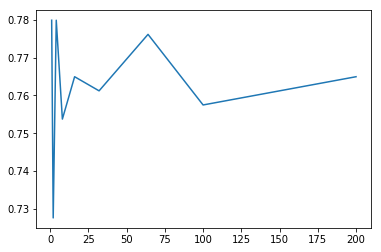

In [24]:
plt.plot(n_estimators, scores)

In [28]:
def make_predictions(test,model,train,filename):
    test_cleaned = preproc(test)
    test_cleaned  = add_missing_dummy_columns(train, test_cleaned)
    predictions = model.predict(test_cleaned)
    predictions_df = pd.concat([test['PassengerId'],pd.DataFrame(predictions)], axis=1)
    predictions_df.columns = ["PassengerId","Survived"]
    predictions_df.to_csv(filename, index=False)
    return predictions_df

def score_predictions(predictions, labels):
    print("Accuracy is {}".format(accuracy_score(labels["Survived"],predictions["Survived"])))
    print("ROC AUC Score is {}".format(roc_auc_score(labels["Survived"],predictions["Survived"])))
    print("F1 Score is {}".format(f1_score(labels["Survived"],predictions["Survived"])))
    print("Confusion matrix:\n{}".format(confusion_matrix(labels["Survived"],predictions["Survived"])))
   

In [63]:
rf_model = RandomForestClassifier(n_estimators = 8)
rf_model.fit(X,y)
predictions = make_predictions(test,rf_model,X,'submission_rf_without_cv.csv')

In [64]:
score_predictions(predictions, labels)

Accuracy is 0.7966507177033493
ROC AUC Score is 0.7838345864661654
F1 Score is 0.7249190938511326
Confusion matrix:
[[221  45]
 [ 40 112]]


#### use cross validation since training set is small

In [31]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

#### Random Forest

In [66]:
rf = RandomForestClassifier()
params = {'n_estimators': [100, 200,300,400,500], 'min_samples_split':np.arange(10,50,10),'criterion':["gini","entropy"]}
rf_model = GridSearchCV(rf, params, cv=StratifiedKFold(n_splits = 5, random_state=77), scoring='accuracy')
rf_model.fit(X,y)
print(rf_model.best_score_)
print(rf_model.best_params_)
predictions = make_predictions(test,rf_model.best_estimator_,X,"rf_cv.csv")

0.8226711560044894
{'criterion': 'gini', 'min_samples_split': 40, 'n_estimators': 500}


In [67]:
score_predictions(predictions, labels)

Accuracy is 0.937799043062201
ROC AUC Score is 0.9215225563909775
F1 Score is 0.9097222222222222
Confusion matrix:
[[261   5]
 [ 21 131]]


In [68]:
for i, feature in enumerate(rf_model.best_estimator_.feature_importances_):
    print(X.columns[i])
    print(feature)

Age
0.11459293158398659
SibSp
0.026074525503552624
Parch
0.02315825184959291
HasSibSp
0.00974410157262381
HasParch
0.014627038212408985
Sex_female
0.26600117138176543
Sex_male
0.26902152380024935
Embarked_C
0.012806425230384685
Embarked_Q
0.008697730215949358
Embarked_S
0.01732895957513753
Cabin_Deck_A
0.0027191804594443917
Cabin_Deck_B
0.01134262800295651
Cabin_Deck_C
0.005301531312088184
Cabin_Deck_D
0.012451720276324253
Cabin_Deck_E
0.021165561787058144
Cabin_Deck_F
0.0029796673244831136
Cabin_Deck_G
0.0011098398683148157
Cabin_Deck_T
0.0002144550030378344
Pclass_1
0.06609153206621701
Pclass_2
0.025515788385650835
Pclass_3
0.08905543658877357


#### AdaBoost

In [36]:
from sklearn.ensemble import AdaBoostClassifier

adb = AdaBoostClassifier()
params = {'n_estimators': np.arange(50,150,10), 'learning_rate' :np.linspace(0.5,1,15)}
adb_model = GridSearchCV(adb, params, cv=StratifiedKFold(n_splits=5,random_state=77), scoring = "accuracy")
adb_model.fit(X,y)
print(adb_model.best_score_)
print(adb_model.best_params_)
adb_pred=make_predictions(test,adb_model,X,"adb_cv.csv")

0.8249158249158249
{'learning_rate': 0.5714285714285714, 'n_estimators': 140}


/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [37]:
score_predictions(adb_pred, labels)

Accuracy is 0.8995215311004785
ROC AUC Score is 0.9041353383458647
F1 Score is 0.8695652173913043
Confusion matrix:
[[236  30]
 [ 12 140]]


#### XGBoost

In [71]:
import warnings
warnings.filterwarnings("ignore")
from xgboost import XGBClassifier

learning_rate = np.linspace(0.01,0.1,10)
n_estimators=np.arange(20,100,20)
reg_lambda=np.linspace(0,1,10)

xgb = XGBClassifier()

params = {'n_estimators':n_estimators, 
          'learning_rate':learning_rate,
         'reg_lambda':reg_lambda}

xgb_model = GridSearchCV(xgb, params, cv=StratifiedKFold(n_splits=5,random_state=77), scoring = "accuracy")

xgb_model.fit(X,y)
print(xgb_model.best_score_)
print(xgb_model.best_params_)
xgb_pred = make_predictions(test,xgb_model,X,"xgb_cv.csv")

0.8428731762065096
{'learning_rate': 0.09000000000000001, 'n_estimators': 60, 'reg_lambda': 0.4444444444444444}


In [72]:
score_predictions(xgb_pred, labels)

Accuracy is 0.8803827751196173
ROC AUC Score is 0.8538533834586466
F1 Score is 0.8214285714285714
Confusion matrix:
[[253  13]
 [ 37 115]]


#### SVC

In [69]:
from sklearn.svm import SVC

C = np.linspace(0.1,1,5)
kernels = ['linear', 'rbf', 'sigmoid']

svc = SVC()

params = {'C':C, 
          'kernel':kernels}

svc_model = GridSearchCV(svc, params, cv=StratifiedKFold(n_splits=5,random_state=77), scoring = "accuracy")

svc_model.fit(X,y)
print(svc_model.best_score_)
print(svc_model.best_params_)
svc_pred = make_predictions(test,svc_model,X,"svc_cv.csv")

0.8181818181818182
{'C': 0.775, 'kernel': 'rbf'}


In [42]:
score_predictions(svc_pred, labels)

Accuracy is 0.9330143540669856
ROC AUC Score is 0.9304511278195489
F1 Score is 0.9090909090909091
Confusion matrix:
[[250  16]
 [ 12 140]]


#### Log regression

In [70]:
from sklearn.linear_model import LogisticRegression

C = np.linspace(0.1,1,10)
log = LogisticRegression()

params = {'C':C}

log_model = GridSearchCV(log, params, cv=StratifiedKFold(n_splits=5,random_state=77), scoring = "accuracy")

log_model.fit(X,y)
print(log_model.best_score_)
print(log_model.best_params_)
log_pred = make_predictions(test,svc_model,X,"log_cv.csv")

0.8103254769921436
{'C': 0.5}


In [44]:
score_predictions(log_pred, labels)

Accuracy is 0.9330143540669856
ROC AUC Score is 0.9304511278195489
F1 Score is 0.9090909090909091
Confusion matrix:
[[250  16]
 [ 12 140]]


In [45]:
X.describe()

,Age,SibSp,Parch,HasSibSp,HasParch,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,...,Cabin_Deck_B,Cabin_Deck_C,Cabin_Deck_D,Cabin_Deck_E,Cabin_Deck_F,Cabin_Deck_G,Cabin_Deck_T,Pclass_1,Pclass_2,Pclass_3
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,...,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,29.390202,0.523008,0.381594,0.317621,0.239057,0.352413,0.647587,0.188552,0.086420,0.722783,...,0.052750,0.066218,0.037037,0.035915,0.014590,0.004489,0.001122,0.242424,0.206510,0.551066
std,13.265322,1.102743,0.806057,0.465813,0.426747,0.477990,0.477990,0.391372,0.281141,0.447876,...,0.223659,0.248802,0.188959,0.186182,0.119973,0.066890,0.033501,0.428790,0.405028,0.497665
min,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,30.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,35.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,80.000000,8.000000,6.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
